In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def read_images(path):
    imgs = {}
    path = os.path.abspath(path)
    for _, _, files in os.walk(path):
        for f in files:
            img = cv2.imread(os.path.join(path, f))
            imgs.update({f[:f.rfind('.')]: cv2.cvtColor(img, cv2.COLOR_BGR2RGB)})
    return imgs

In [3]:
def read_labels(path):
    labels = {}
    path = os.path.abspath(path)
    for _, _, files in os.walk(path):
        for f in files:
            if f.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, f))
                for i in range(len(df)):
                    labels.update({df['image'][i]:df['level'][i]})
    return labels

In [4]:
imgs_dict = read_images('../data/images')
labels_dict = read_labels('../data/labels')

# Display images

In [5]:
def display_images(images, MAX_ROW=10):
    fig = plt.figure(figsize=(12, 8))
    rows = int((len(images)+1)/3)+1
    if MAX_ROW is not None:
        if rows > MAX_ROW:
            rows = int(MAX_ROW)
    for i, im in enumerate(images):
        a = fig.add_subplot(rows, 3, i+1)
        plt.imshow(im)

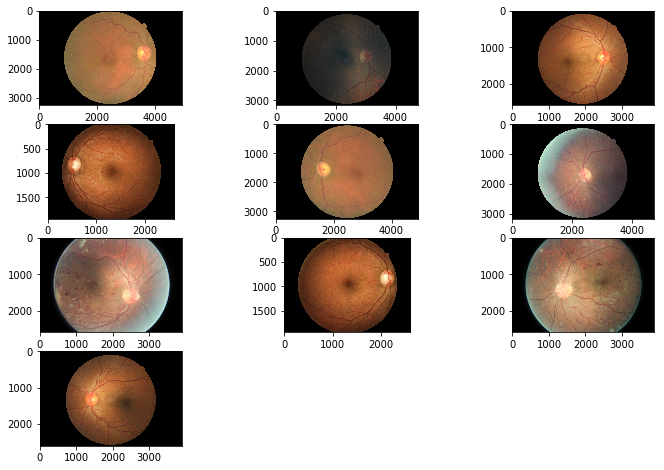

In [6]:
display_images(imgs_dict.values())

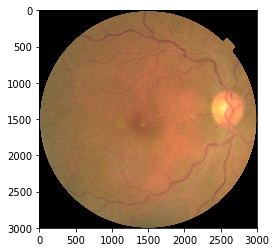

In [9]:
def auto_crop_and_resize(image, resize_dims=False):
    '''
    Crop the major content from the image and resize to a wanted size.
    
    @param image
        The input image
        
    @param resize_dims
        To keep the origin shape, set it to False.
        Or give the specific shape of the wanted output.
    '''
    # Canny edge detector
    image_edges = cv2.Canny(image, 20, 30)
    # find the proper fully sized edges
    start_y, end_y = _find_start_end_indices(image_edges, axis=0)
    start_x, end_x = _find_start_end_indices(image_edges, axis=1)
    # crop
    image = image[start_x:end_x, start_y:end_y, :]
    if resize_dims is not False:
        # resize
        image = cv2.resize(image, resize_dims)
    return image

def _find_start_end_indices(image, axis, threshold=3):
    '''
    Filter out the non-zero indices which means to carry contents.
    @param image
    @param axis
    @param threshold
        Ignore a specific number of pixels for each column.
        If the column carries less than threshold pixel numbers,
        it will be filtered.
    '''
    assert len(image.shape) == 2, "Must input a grayscaled image."
    hist_along_axis = np.count_nonzero(image, axis=axis)
#     plt.bar(range(hist_along_axis.shape[0]), hist_along_axis)
    idx_x = np.argwhere(hist_along_axis > threshold)
    return (idx_x[0][0], idx_x[-1][0])
    
plt.imshow(auto_crop_and_resize(list(imgs_dict.values())[0], (3000, 3000)))

# To TFRecords

In [10]:
def _int64_feature(value):
    return tf.train.Feature(
            int64_list=tf.train.Int64List(value=value)
         )
def _floats_feature(value):
    return tf.train.Feature(
               float_list=tf.train.FloatList(value=value)
           )

def _bytes_feature(value):
    return tf.train.Feature(
              bytes_list=tf.train.BytesList(value=value)
         )

In [11]:
import tensorflow as tf
def get_feature(image, label):
    return {
        'label': _int64_feature([label]),
        'image': _bytes_feature(
                 # Note the square brackets here, to be a 1D list
                    [tf.compat.as_bytes(image.tostring())]
                 )
    }

/Users/JianS/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
def to_TFRecords(images, labels):
    images = list(images)
    labels = list(labels)
#     print(labels)
    assert len(images) == len(labels), 'Must have equivalent number of images and labels.'
    output_file_path = 'data.tfrecords'
    with tf.python_io.TFRecordWriter(output_file_path) as writer:
            for i in range(len(images)):
                example = tf.train.Example(
                  features=tf.train.Features(
                      feature = get_feature(
                                auto_crop_and_resize(images[i], (3000, 3000)),
                                labels[i])
                ))
                writer.write(example.SerializeToString())
                print('\r{:.1%}'.format((i+1)/len(images)), end='')

In [13]:
to_TFRecords(images=imgs_dict.values(), labels=labels_dict.values())

100.0%